<a href="https://colab.research.google.com/github/Kravty/MachineLearning/blob/main/Face_Detection_RetinaNet_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2> This notebook uses pretrained model of RetinaNet, learnt on Coco dataset, on custom data, more specifically Face Detection dataset from kaggle (face was not category of Coco dataset)

<h3> Installation of the RetinaNet library

In [1]:
!git clone https://github.com/fizyr/keras-retinanet.git

Cloning into 'keras-retinanet'...
remote: Enumerating objects: 6205, done.
remote: Total 6205 (delta 0), reused 0 (delta 0), pack-reused 6205
Receiving objects: 100% (6205/6205), 14.87 MiB | 36.00 MiB/s, done.
Resolving deltas: 100% (4195/4195), done.


In [2]:
%cd keras-retinanet/
!pip install .

/content/keras-retinanet
Processing /content/keras-retinanet
  Created wheel for keras-retinanet: filename=keras_retinanet-1.0.0-cp36-cp36m-linux_x86_64.whl size=167020 sha256=4730bbac2bfdf23d454ec3643b45b5126a21f4754fe2b98de6321d6b4ad81ca9
  Stored in directory: /root/.cache/pip/wheels/b2/9f/57/cb0305f6f5a41fc3c11ad67b8cedfbe9127775b563337827ba
  Created wheel for keras-resnet: filename=keras_resnet-0.2.0-py2.py3-none-any.whl size=20486 sha256=19e08aa07e720538c2d305d314ea90df78900a157024a82c399cfec993212acd
  Stored in directory: /root/.cache/pip/wheels/5f/09/a5/497a30fd9ad9964e98a1254d1e164bcd1b8a5eda36197ecb3c
Successfully built keras-retinanet keras-resnet


In [3]:
!python setup.py build_ext --inplace

running build_ext
cythoning keras_retinanet/utils/compute_overlap.pyx to keras_retinanet/utils/compute_overlap.c
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/keras-retinanet/keras_retinanet/utils/compute_overlap.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'keras_retinanet.utils.compute_overlap' extension
creating build
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/keras_retinanet
creating build/temp.linux-x86_64-3.6/keras_retinanet/utils
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/include/python3.6m -I/usr/local/lib/python3.6/dist-packages/numpy/core/include -c keras_retinanet/utils/compute_overlap.c -o build/temp.linux-x86_64-3.6/keras_retinanet/utils/compute_over

<h3> Import of libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import requests
import urllib
import os
from PIL import Image
import json

from keras_retinanet import models
from keras_retinanet.utils.image import preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

<h3> Data preparation 

In [5]:
%cd ..
!wget -nc https://raw.githubusercontent.com/Kravty/MachineLearning/main/Datasets/face_detection.json

/content
--2021-01-09 15:12:49--  https://raw.githubusercontent.com/Kravty/MachineLearning/main/Datasets/face_detection.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 273830 (267K) [text/plain]
Saving to: ‘face_detection.json’

face_detection.json 100%[===================>] 267.41K  --.-KB/s    in 0.02s   

2021-01-09 15:12:49 (12.3 MB/s) - ‘face_detection.json’ saved [273830/273830]



In [6]:
!head face_detection.json

{"content": "http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb064277d86016431e33e4e003d/8186c3d1-e9d4-4550-8ec1-a062a7628787___0-26.jpg.jpeg","annotation":[{"label":["Face"],"notes":"","points":[{"x":0.08615384615384615,"y":0.3063063063063063},{"x":0.1723076923076923,"y":0.45345345345345345}],"imageWidth":650,"imageHeight":333},{"label":["Face"],"notes":"","points":[{"x":0.583076923076923,"y":0.2912912912912913},{"x":0.6584615384615384,"y":0.46846846846846846}],"imageWidth":650,"imageHeight":333}],"extras":null}
{"content": "http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb064277d86016431e33e4e003d/d1c32c8e-8050-482d-a6c8-b101ccba5b65___0de0ee708a4a47039e441d488615ebb7.png","annotation":[{"label":["Face"],"notes":"","points":[{"x":0.7053087757313109,"y":0.23260437375745527},{"x":0.7692307692307693,"y":0.36182902584493043}],"imageWidth":1280,"imageHeight":697}],"extras":null}
{"content": "http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb064277d86016431e33e4e00

In [7]:
j = json.loads(open('face_detection.json').readline())
j

{'annotation': [{'imageHeight': 333,
   'imageWidth': 650,
   'label': ['Face'],
   'notes': '',
   'points': [{'x': 0.08615384615384615, 'y': 0.3063063063063063},
    {'x': 0.1723076923076923, 'y': 0.45345345345345345}]},
  {'imageHeight': 333,
   'imageWidth': 650,
   'label': ['Face'],
   'notes': '',
   'points': [{'x': 0.583076923076923, 'y': 0.2912912912912913},
    {'x': 0.6584615384615384, 'y': 0.46846846846846846}]}],
 'content': 'http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb064277d86016431e33e4e003d/8186c3d1-e9d4-4550-8ec1-a062a7628787___0-26.jpg.jpeg',
 'extras': None}

In [8]:
df = pd.read_json('face_detection.json', lines=True)
print(f'Shape of dataframe is {df.shape}.\nHead of dateframe:')
df.head()

Shape of dataframe is (409, 3).
Head of dateframe:


,content,annotation,extras
0,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['Face'], 'notes': '', 'points': [{...",NaN
1,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['Face'], 'notes': '', 'points': [{...",NaN
2,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['Face'], 'notes': '', 'points': [{...",NaN
3,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['Face'], 'notes': '', 'points': [{...",NaN
4,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['Face'], 'notes': '', 'points': [{...",NaN


<h3> Testing input data before training

In [9]:
r = requests.get('http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb064277d86016431e33e4e003d/e53eb4ea-9e38-4f94-a102-529a878b1fbd___18q0dngvi7ic2jpg.jpg.jpeg')
with open('testimg.jpg', 'wb') as f:
  f.write(r.content)

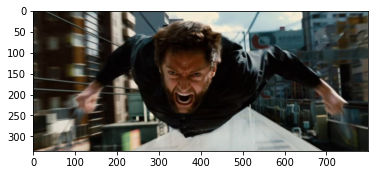

In [10]:
im = Image.open('testimg.jpg')
plt.imshow(im);

In [11]:
# Converting the train and test data to the format suitable for Keras RetinaNet library
# Expected data is: name (local file path), bounding box, class name (in this case 'face')
converted_data_train = {
    'image_name': [],
    'x_min': [],
    'y_min': [],
    'x_max': [],
    'y_max': [],
    'class_name': [],
}

converted_data_test = {
    'image_name': [],
    'x_min': [],
    'y_min': [],
    'x_max': [],
    'y_max': [],
    'class_name': [],
}

In [12]:
# Creating directory for storing the images locally
# In the original dataset, the images are only urls
if not os.path.exists('faces'):
  os.mkdir('faces')

In [13]:
# Function used to populate created dictionaries
# The pandas apply function will be used on this function (appropriate format)

idx = 0 # Global counter for filenames

def map_to_data(row, converted_data):
  global idx
  r = requests.get(row['content'])
  filepath = 'faces/face_%s.jpg' % idx

  if not os.path.exists(filepath):
    with open(filepath, 'wb') as f:
      f.write(r.content)

  # In case of more than 1 face per image
  for anno in row['annotation']:
    converted_data['image_name'].append(filepath)

    width = anno['imageWidth']
    height = anno['imageHeight']

    # Calculation of bounding box coordinates
    x1 = int(round(anno['points'][0]['x'] * width))
    y1 = int(round(anno['points'][0]['y'] * height))
    x2 = int(round(anno['points'][1]['x'] * width))
    y2 = int(round(anno['points'][1]['y'] * height))

    converted_data['x_min'].append(x1)
    converted_data['y_min'].append(y1)
    converted_data['x_max'].append(x2)
    converted_data['y_max'].append(y2)
    
    converted_data['class_name'].append('face')
  
  # Update of counter outside of the loop
  idx += 1

In [14]:
# Spliting (must be done before converting the data)
# Otherwise multiple rows will have the same image (one row per object instead of one per image)
train_df, test_df = train_test_split(df, test_size=0.2)

In [15]:
# Train data
train_df.apply(lambda row: map_to_data(row, converted_data_train), axis=1)
# Test data
test_df.apply(lambda row: map_to_data(row, converted_data_test), axis=1)

237    None
93     None
60     None
391    None
181    None
       ... 
228    None
317    None
173    None
184    None
366    None
Length: 82, dtype: object

In [16]:
# Overwriting the previous dataframes
train_df = pd.DataFrame(converted_data_train)
test_df = pd.DataFrame(converted_data_test)
print(f'Shape of dataframe is {train_df.shape}.\nHead of dateframe:')
train_df.head()

Shape of dataframe is (928, 6).
Head of dateframe:


,image_name,x_min,y_min,x_max,y_max,class_name
0,faces/face_0.jpg,109,112,291,286,face
1,faces/face_0.jpg,311,192,432,309,face
2,faces/face_0.jpg,499,203,641,327,face
3,faces/face_0.jpg,892,116,1058,313,face
4,faces/face_1.jpg,61,107,166,217,face


In [17]:
# Function will plot random image along with its ground truth bounding boxes

def show_image_with_boxes(df):
  
  # Filepath should be string
  filepath = df.sample()['image_name'].values[0]

  # Get all rows for this image
  df2 = df[df['image_name'] == filepath]
  im = np.array(Image.open(filepath))

  # PNG files have additionat 4th channel (transparency)
  # Keras's image manipulation doesn't work properly with this extra dimension
  # The forth channel is removed (if there is one)
  im = im[:,:,:3]

  for idx, row in df2.iterrows():
    box = [
      row['x_min'],
      row['y_min'],
      row['x_max'],
      row['y_max'],
    ]
    print(box)
    draw_box(im, box, color=(255, 0, 0))

  plt.axis('off')
  plt.imshow(im)
  plt.show();

[689, 43, 786, 202]
[1069, 355, 1267, 528]
[237, 362, 403, 486]
[62, 354, 206, 533]


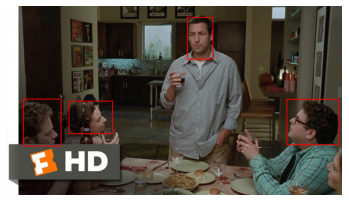

In [18]:
show_image_with_boxes(train_df)

In [19]:
# Saving to files
train_df.to_csv('annotations.csv', index=False, header=None)

classes = ['face']
with open('classes.csv', 'w') as f:
  for i, class_name in enumerate(classes):
    f.write(f'{class_name},{i}\n')

In [20]:
!head classes.csv

face,0


In [21]:
!head annotations.csv

faces/face_0.jpg,109,112,291,286,face
faces/face_0.jpg,311,192,432,309,face
faces/face_0.jpg,499,203,641,327,face
faces/face_0.jpg,892,116,1058,313,face
faces/face_1.jpg,61,107,166,217,face
faces/face_1.jpg,156,7,260,156,face
faces/face_1.jpg,243,73,310,183,face
faces/face_1.jpg,315,43,413,174,face
faces/face_2.jpg,1010,238,1361,744,face
faces/face_2.jpg,520,274,680,516,face


In [22]:
# Directory for storing saved models
# Training script saves the model after each epoch
if not os.path.exists('snapshots'):
  os.mkdir('snapshots')

<h3> Training the model

In [23]:
PRETRAINED_MODEL = 'snapshots/_pretrained_model.h5'

URL_MODEL = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5'
urllib.request.urlretrieve(URL_MODEL, PRETRAINED_MODEL)

print('Downloaded pretrained model to ' + PRETRAINED_MODEL)

Downloaded pretrained model to snapshots/_pretrained_model.h5


In [24]:
# Calculating step per epoch
batch_size = 8
num_images = len(train_df.groupby('image_name'))
steps_per_epoch = num_images // batch_size + 1
print(f'There are {steps_per_epoch} steps per epoch')

There are 41 steps per epoch


In [25]:
!keras-retinanet/keras_retinanet/bin/train.py --freeze-backbone \
  --random-transform \
  --weights {PRETRAINED_MODEL} \
  --batch-size {batch_size} \
  --steps {steps_per_epoch} \
  --epochs 15 \
  csv annotations.csv classes.csv

2021-01-09 15:15:16.353681: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
Creating model, this may take a second...
2021-01-09 15:15:18.344905: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-01-09 15:15:18.346197: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-01-09 15:15:18.389427: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-01-09 15:15:18.390052: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-01-09 15:15:18.390088:

In [26]:
# Overview of saved models
!ls snapshots

_pretrained_model.h5  resnet50_csv_06.h5  resnet50_csv_12.h5
resnet50_csv_01.h5    resnet50_csv_07.h5  resnet50_csv_13.h5
resnet50_csv_02.h5    resnet50_csv_08.h5  resnet50_csv_14.h5
resnet50_csv_03.h5    resnet50_csv_09.h5  resnet50_csv_15.h5
resnet50_csv_04.h5    resnet50_csv_10.h5
resnet50_csv_05.h5    resnet50_csv_11.h5


In [27]:
# Loading the model (after final epoch)
from glob import glob

model_paths = glob('snapshots/resnet50_csv_*.h5')
latest_path = sorted(model_paths)[-1]
print("path:", latest_path)

model = models.load_model(latest_path, backbone_name='resnet50')
model = models.convert_model(model)

label_map = {}
for line in open('classes.csv'):
  row = line.rstrip().split(',')
  label_map[int(row[1])] = row[0]

path: snapshots/resnet50_csv_15.h5


In [32]:
# Function that plots random image with predicted bounding boxes together with ground truth bounding boxes
def show_image_with_predictions(df, threshold=0.6):

  row = df.sample()
  filepath = row['image_name'].values[0]
  print("filepath:", filepath)

  # Get all rows for this image
  df2 = df[df['image_name'] == filepath]
  im = np.array(Image.open(filepath))
  print(f"Image dimensions: {im.shape}")

  # PNG files have additionat 4th channel (transparency)
  # Keras's image manipulation doesn't work properly with this extra dimension
  # The forth channel is removed (if there is one)
  im = im[:,:,:3]

  # Plotting ground truth bounding boxes (red)
  for idx, row in df2.iterrows():
    box = [
      row['x_min'],
      row['y_min'],
      row['x_max'],
      row['y_max'],
    ]
    print(box)
    draw_box(im, box, color=(255, 0, 0))

  # Getting predictions
  imp = preprocess_image(im)
  imp, scale = resize_image(im)

  boxes, scores, labels = model.predict_on_batch(
    np.expand_dims(imp, axis=0)
  )

  # Standardizing box coordinates
  boxes /= scale

  # Loop through each prediction for the input image 
  # Assuming one sample in batch
  for box, score, label in zip(boxes[0], scores[0], labels[0]):
    # Scores are sorted so we can quit as soon as a score is below threshold
    if score < threshold:
      break

    # Drawing boxes on detected objects
    box = box.astype(np.int32)
    # Box color for each detected label should be different
    color = label_color(label)
    draw_box(im, box, color=color)

    # Drawing captions for detected objects
    class_name = label_map[label]
    caption = f"{class_name} {score:.3f}"
    draw_caption(im, box, caption)

  plt.axis('off')
  plt.imshow(im)
  plt.show()

In [29]:
# Scaling the output size of an image
plt.rcParams['figure.figsize'] = [20, 10]

filepath: faces/face_143.jpg
Image dimensions: (346, 614, 3)
[256, 35, 393, 213]


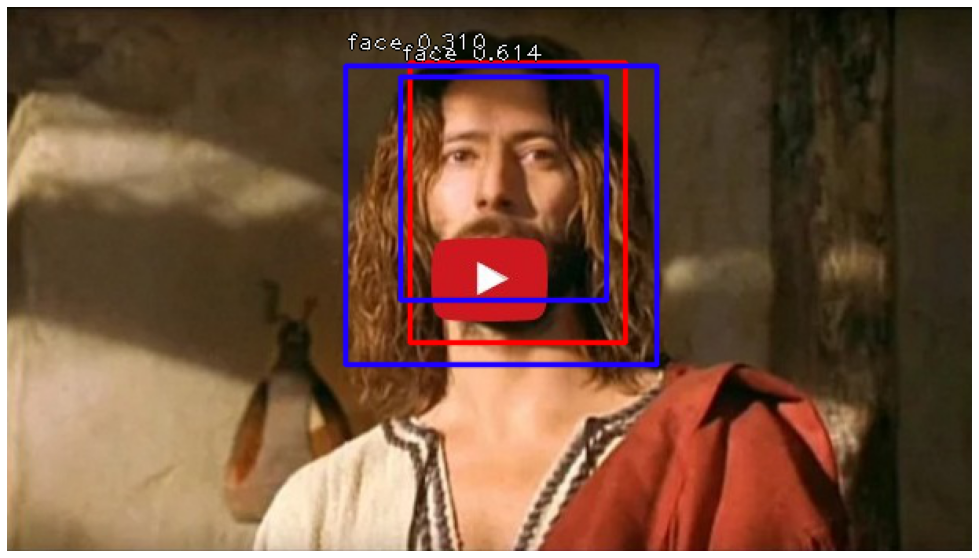

In [33]:
show_image_with_predictions(train_df, threshold=0.3)

filepath: faces/face_347.jpg
Image dimensions: (282, 425, 3)
[59, 98, 139, 186]
[125, 58, 219, 133]
[208, 23, 285, 127]
[297, 28, 369, 135]


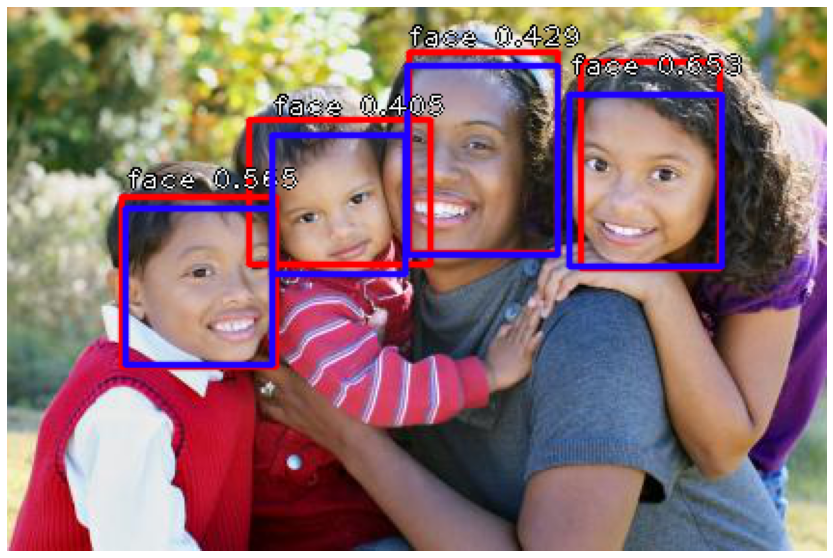

In [35]:
show_image_with_predictions(test_df, threshold=0.4)